In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import Dataset

In [47]:
torch.randn(dataset.fx.shape).shape

torch.Size([100, 120])

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset


class time_series_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        # add noise
        self.fx = self.fx + torch.randn(self.fx.shape)
        
        self.masks = self._generate_square_subsequent_mask(24+1)
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #sample = {"x":self.x[idx,0:self.t0],
        #          "x_next":self.x[idx,self.t0:self.t0+24],
        #          "fx": self.fx[idx,0:self.t0],
        #          "fx_next":self.fx[idx,self.t0:self.t0+24],
        #          "attention_masks":self.masks}
        
        sample = (self.x[idx,0:self.t0-1],
                  self.x[idx,self.t0-1:self.t0+24],
                  self.fx[idx,0:self.t0-1],
                  self.fx[idx,self.t0-1:self.t0+24],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [459]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset


class time_series_decoder_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        # add noise
        self.fx = self.fx + torch.randn(self.fx.shape)
        
        self.masks = self._generate_square_subsequent_mask(t0)
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        sample = (self.x[idx,:],
                  self.fx[idx,:],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(t0+24,t0+24)
        for i in range(0,t0):
            mask[i,t0:] = 1 
        for i in range(t0,t0+24):
            mask[i,i+1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
        return mask

In [474]:
d = time_series_decoder_paper(96,100)

x: 100*120 fx: 100*120


In [380]:
class time_series_missing_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,missing_chunk=50,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        # add noise
        self.fx = self.fx + torch.randn(self.fx.shape)
        

        src_mask = torch.zeros(t0-1,t0-1)
        
        self.fx_missing = torch.zeros((N,t0+24-missing_chunk)) 
        self.x_missing = torch.zeros((N,t0+24-missing_chunk)) 
        
        self.x_prior = torch.zeros((N,t0-1-missing_chunk))
        self.x_post = torch.zeros((N,1+24))
        self.fx_prior = torch.zeros((N,t0-1-missing_chunk))
        self.fx_post = torch.zeros((N,1+24))
        
        for j in range(0,self.fx.shape[0]):
            missing_idx = torch.randint(24,t0-1-missing_chunk,(1,)).item()
            desired_idx = torch.LongTensor([i for i in np.arange(0,t0+24) if i not in np.arange(missing_idx,missing_idx+missing_chunk)])
            
            
            self.fx_missing[j,:] = self.fx[j,desired_idx]
            self.x_missing[j,:] = self.x[j,desired_idx]
                        
            idx1 = desired_idx[desired_idx < (t0-1)].squeeze()
            idx2 = desired_idx[desired_idx >= (t0-1)].squeeze()

            self.x_prior[j,:] = self.x[j,idx1]
            self.x_post[j,:] = self.x[j,idx2]
            self.fx_prior[j,:] = self.fx[j,idx1]
            self.fx_post[j,:] = self.fx[j,idx2]
        
            
        self.masks = self._generate_square_subsequent_mask(24+1)
        
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #sample = {"x":self.x[idx,0:self.t0],
        #          "x_next":self.x[idx,self.t0:self.t0+24],
        #          "fx": self.fx[idx,0:self.t0],
        #          "fx_next":self.fx[idx,self.t0:self.t0+24],
        #          "attention_masks":self.masks}
        
        sample = (self.x_prior[idx],
                  self.x_post[idx],
                  self.fx_prior[idx],
                  self.fx_post[idx],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [406]:
t0 = 96
N = 100

# Missing Dataset

In [382]:
dataset_missing = time_series_missing_paper()

x: 4500*120 fx: 4500*120


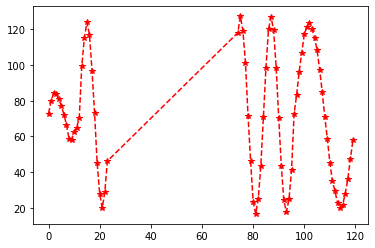

In [388]:
idx = torch.randint(0,N,(1,)).item()
plt.plot(dataset_missing.x_missing[idx].numpy(),dataset_missing.fx_missing[idx].numpy(),'r*--')
plt.show()

# Regular dataset

In [216]:
dataset_missing.fx[99]

tensor([ 70.5897,  71.3960,  74.2224,  72.7838,  73.0146,  73.4754,  71.6909,
         71.5867,  69.3949,  69.7779,  69.7159,  71.5530,  72.4754,  84.1934,
         94.2802,  97.8591,  94.3799,  88.1868,  71.4238,  58.6138,  49.9049,
         46.5077,  48.8446,  59.6799,  71.7918,  97.0033, 114.5875, 121.6640,
        115.5731,  96.6806,  71.4558,  47.1842,  26.2378,  22.8943,  28.7757,
         46.8186,  72.5706,  97.6164, 115.9201, 122.0926, 117.1975,  96.7661,
         72.4509,  48.7585,  29.9226,  22.0713,  28.6758,  45.4245,  70.9435,
         96.5456, 113.8798, 122.3693, 115.9229,  96.7538,  70.6459,  45.6632,
         29.7052,  24.0197,  26.9687,  45.9147,  72.1766,  95.9173, 114.9766,
        119.2269, 114.9331,  98.0689,  72.2302,  48.4391,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.00

In [5]:
dataset = time_series_paper(t0,N)

x: 100*120 fx: 100*120


In [6]:
dataset.masks

tensor([[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -

In [7]:
dataset.fx

tensor([[ 72.0000,  98.3769, 117.6861,  ...,  34.6975,  45.6231,  58.3464],
        [ 72.0000,  82.8903,  90.8626,  ...,  36.7838,  47.0984,  59.1101],
        [ 72.0000,  81.8153,  89.0006,  ...,  33.1989,  44.5635,  57.7979],
        ...,
        [ 72.0000,  73.8335,  75.1756,  ...,  45.5544,  53.3001,  62.3203],
        [ 72.0000,  86.0004,  96.2494,  ...,  45.4442,  53.2222,  62.2799],
        [ 72.0000,  84.5199,  93.6852,  ...,  54.2942,  59.4801,  65.5192]])

In [8]:
dataset.x

tensor([[  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        ...,
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.]])

In [9]:
dataset[0]

{'x': tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
         56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
         70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
         84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.]),
 'x_next': tensor([ 96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
         108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.]),
 'fx': tensor([ 72.0000,  98.3769, 117.6861, 124.7538, 117.6861,  98.3769,  72.0000,
          45.6231,  26.3139,  19.2462,  26.3139,  45.6231,  72.0000,  78.8723,
          83.9031,  85.7445,  83.9031,  78.8723,  72.0000,  65.1277,  60.0969,
          58.2555,  60.0969,  65.

In [18]:
encoded_dict =  dataset[0:1]

In [19]:
for key,value in encoded_dict.items():
    print("{}: ".format(key),value.shape)

x:  torch.Size([1, 96])
x_next:  torch.Size([1, 24])
fx:  torch.Size([1, 96])
fx_next:  torch.Size([1, 24])
attention_masks:  torch.Size([24, 24])


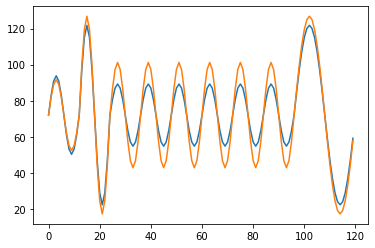

In [12]:
plt.plot(dataset.x[1].numpy(),dataset.fx[1].numpy())
plt.plot(dataset.x[2].numpy(),dataset.fx[2].numpy())
plt.show()